# Análise de Inadimplência e Score para Prospects

Este notebook tem como objetivo:

1. Desenvolver um modelo preditivo para probabilidade de inadimplêmcia usando a base de clientes
2. Aplicar o modelo de clientes na base prospects
3. Calcular o score para os propects
4. Gerar arquivo final com score para prospects

## Importar bibliotecas necessárias

In [1]:
# pipenv install ipykernel pandas plotly numpy matplotlib seaborn scipy colorama scikit-learn optuna joblib nbformat

In [2]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# Otimização
import optuna

# Utilitários
import joblib
import math

/home/emerson/.local/share/virtualenvs/final_challenge-Iu6pVGne/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abrir Base Clientes

In [3]:
df_clientes = pd.read_csv('./dataset/clientes.csv')

In [4]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

### Visualizar primeiros e últimos registros

In [5]:
print('Primeiros registros:')
display(df_clientes.head())

print('\nÚltimos registros:')
display(df_clientes.tail())

Primeiros registros:


,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
0,bc3749c2-932f-462b-a71e-d1a352510f67,Nicole Lopes,32,5,4,2,4,5,3,1,2,4,Brasília,Engenheiro agrônomo,Divorciado,4,2,Próprio,True,34118,631262,55649,294254,0.00000,232,Rocketseat Mastercard Travel Elite
1,981dffc4-087e-4a99-bbac-062944f9b5a7,Kevin Teixeira,42,1,4,5,1,4,1,5,3,5,Campo Grande,Psicólogo,Divorciado,18,2,Alugado,True,7338,376417,1777324,180331,87.00000,27,Rocketseat Mastercard Life Basic
2,242f4e94-7f2a-4557-a27a-9227cca55e83,Augusto Sá,67,4,3,4,3,2,3,3,2,3,Goiânia,Intérprete de Bíblias,Solteiro,19,6,Alugado,True,19965,83667,1793731,122049,78.45000,57,Rocketseat Mastercard Travel Basic
3,e6f16b89-d9bf-4448-9d08-65957cdc1fb3,Ágatha Moura,47,2,3,1,2,1,3,4,3,1,Porto Alegre,Engenheiro de projetos,Divorciado,6,6,Próprio,False,25867,283060,1940685,335544,85.21000,32,Rocketseat Visa Travel Basic
4,79b7f5b0-e754-4cd9-9150-ed5913fef23a,João Rios,27,3,5,4,5,4,3,2,2,5,Fortaleza,Cantor,Solteiro,1,1,Alugado,True,18359,146413,517215,390588,89.12000,0,Rocketseat Visa Life Basic



Últimos registros:


,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
995,c149900a-b482-4fef-b4bb-c3302751a87c,Oliver Freitas,79,1,5,5,3,5,3,3,2,2,Florianópolis,Enfermeiro,Viúvo,13,5,Alugado,False,32710,268881,1900126,367348,77.37000,54,Rocketseat Visa Life Basic
996,4e5af7db-8c74-4931-8daa-06277afacc45,Ian Peixoto,26,4,1,5,5,2,4,2,3,5,Rio de Janeiro,Cadista,Casado,2,1,Próprio,False,40005,269579,585165,247577,82.07000,47,Rocketseat Mastercard Life Basic
997,b2bd8201-8bc8-436e-9afd-7ad6a4c65f86,Srta. Marina Borges,27,2,2,1,4,3,2,3,4,3,Recife,Tecnólogo em produção de bebidas,Casado,10,2,Próprio,True,24055,812314,1177509,348120,82.08000,49,Rocketseat Visa Life Basic
998,f7bb4a7a-2551-4f39-b1b6-f564754580bc,Benjamim Costa,73,4,2,5,5,2,3,3,5,5,Porto Alegre,Gourmet,Divorciado,5,3,Alugado,False,18891,572176,913145,20404,47.23000,210,Rocketseat Visa Life Elite
999,4477389d-ae32-451c-bd52-359699bf94a8,Sra. Evelyn Machado,43,4,4,3,1,4,3,4,5,3,Brasília,Contabilista,Solteiro,11,4,Alugado,True,10037,566432,99473,173459,2.22000,119,Rocketseat Mastercard Shopping Select


### Mostrar estatísticas das variáveis numéricas

In [6]:
# Remover colunas únicas
df_clientes.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [7]:
num_vars = df_clientes.select_dtypes(include=['number']).columns
cat_vars = df_clientes.select_dtypes(include=['object']).columns
target = 'Probabilidade Inadimplencia'
display(df_clientes[num_vars].describe().T)

,count,mean,std,min,25%,50%,75%,max
Idade,1000.00000,49.43200,18.31980,18.00000,34.00000,49.00000,66.00000,80.00000
Viagens,1000.00000,2.98600,1.40277,1.00000,2.00000,3.00000,4.00000,5.00000
Restaurantes,1000.00000,3.02300,1.41791,1.00000,2.00000,3.00000,4.00000,5.00000
Entretenimento,1000.00000,3.07300,1.39198,1.00000,2.00000,3.00000,4.00000,5.00000
Cashback,1000.00000,2.98500,1.38878,1.00000,2.00000,3.00000,4.00000,5.00000
Compras online,1000.00000,2.99900,1.42303,1.00000,2.00000,3.00000,4.00000,5.00000
Farmácias,1000.00000,2.97900,1.38437,1.00000,2.00000,3.00000,4.00000,5.00000
Programas de Milhagem,1000.00000,3.00300,1.45984,1.00000,2.00000,3.00000,4.00000,5.00000
Postos de Combustível,1000.00000,3.09100,1.43205,1.00000,2.00000,3.00000,4.00000,5.00000
Mercados,1000.00000,3.00100,1.43912,1.00000,2.00000,3.00000,4.00000,5.00000


### Mostrar valores possíveis para as variáveis categóricas

In [8]:
for var in cat_vars:
  print(f"\n{var}: {df_clientes[var].nunique()} valores únicos")
  print(df_clientes[var].value_counts().head())


Cidade: 15 valores únicos
Cidade
Goiânia           77
Porto Alegre      74
Rio de Janeiro    74
São Paulo         73
Florianópolis     72
Name: count, dtype: int64

Cargo: 565 valores únicos
Cargo
Gestor de recursos humanos    6
Comandante                    6
Transcritor                   5
Catador de carangueijos       5
Jogador de badminton          5
Name: count, dtype: int64

Estado Civil: 4 valores únicos
Estado Civil
Casado        259
Viúvo         257
Divorciado    247
Solteiro      237
Name: count, dtype: int64

Moradia: 2 valores únicos
Moradia
Próprio    507
Alugado    493
Name: count, dtype: int64

Principal Cartão: 24 valores únicos
Principal Cartão
Rocketseat Mastercard Life Basic        149
Rocketseat Visa Life Basic              132
Rocketseat Mastercard Travel Basic      108
Rocketseat Visa Travel Basic             92
Rocketseat Mastercard Shopping Basic     92
Name: count, dtype: int64


### Apresentar histograma das variáveis numéricas

In [9]:
# Número de colunas desejadas
num_cols = 3

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(num_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(num_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1
  fig.add_trace(
    go.Histogram(x=df_clientes[var], name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=300*num_rows,
  width=1200,
  title_text="Histograma das Variáveis Numéricas",
  showlegend=False,
)

fig.show()

### Gráfico de barras para variáveis categóricas

In [10]:
# Número de colunas desejadas
num_cols = 3

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(cat_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1
  fig.add_trace(
    go.Bar(
      x=df_clientes[var].value_counts().index[:10],
      y=df_clientes[var].value_counts()[:10],
      name=var,
    ),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=500*num_rows,
  width=1200,
  title_text="Gráficos de Barras das Variáveis Categóricas",
  showlegend=False,
)

fig.show()

### Boxplot entre variáveis categóricas e target

In [11]:
# Calcular o número de linhas necessárias
num_cols = 2
num_rows = math.ceil(len(cat_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1
  fig.add_trace(
    go.Box(
      y=df_clientes[target],
      x=df_clientes[var],
      name=var,
    ),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=600*num_rows,
  width=1200,
  title_text="BoxPlots das Variáveis Categóricas vs Probabilidade de Inadimplência",
  showlegend=False,
)

fig.show()

### Matriz de correlação

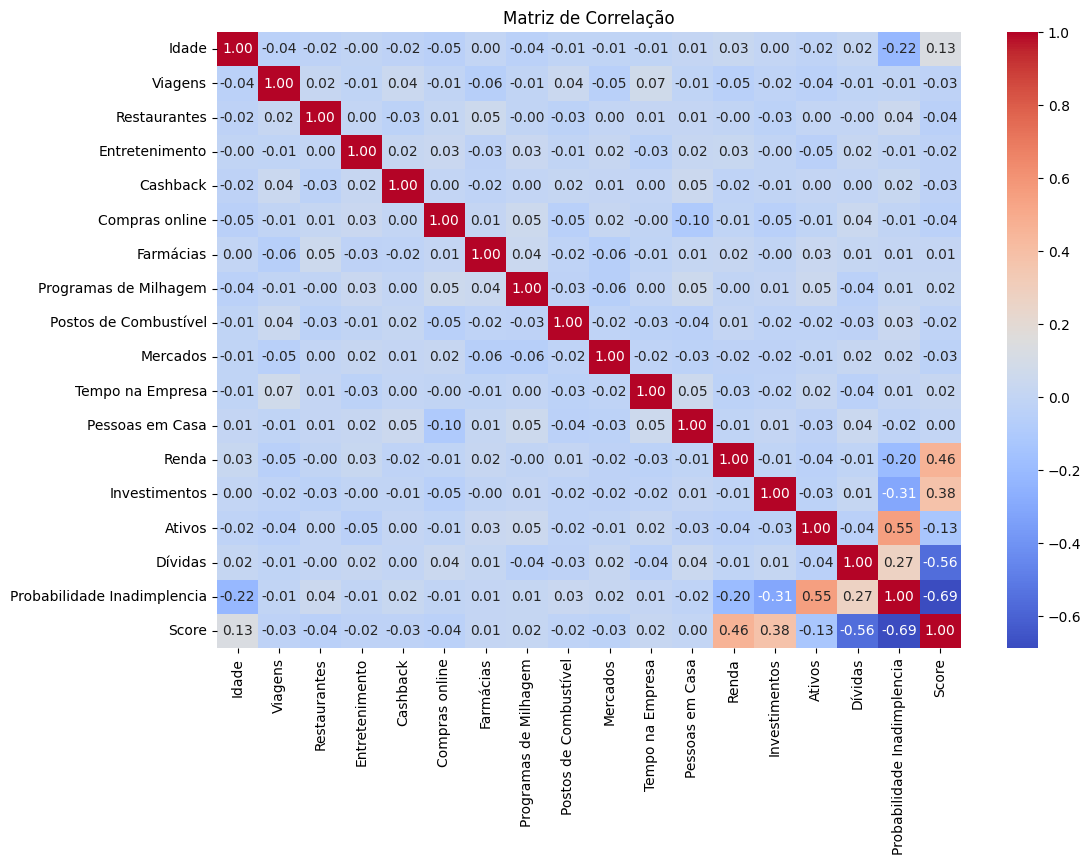

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clientes[num_vars].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Testes de Hipóteses

In [13]:
# Testes de hipóteses para variáveis categóricas (Qui-quadrado)
for cat_col in cat_vars:
  contingency_table = pd.crosstab(df_clientes[cat_col], df_clientes[target])
  chi2, p, dof, _ = chi2_contingency(contingency_table)
  print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
    f"Teste Qui-Quadrado entre {cat_col} e {target}: p-value = {p}"
  )

Teste Qui-Quadrado entre Cidade e Probabilidade Inadimplencia: p-value = 0.3840071939383141
Teste Qui-Quadrado entre Cargo e Probabilidade Inadimplencia: p-value = 0.1253795359986711
Teste Qui-Quadrado entre Estado Civil e Probabilidade Inadimplencia: p-value = 0.48352948196643847
Teste Qui-Quadrado entre Moradia e Probabilidade Inadimplencia: p-value = 0.37283145381687693
Teste Qui-Quadrado entre Principal Cartão e Probabilidade Inadimplencia: p-value = 1.0


### Treinar RandomForestRegressor

In [15]:
selected_features = ['Idade', 'Renda', 'Investimentos', 'Ativos', 'Dívidas']
X = df_clientes[selected_features]
y = df_clientes[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"RMSE médio na validação cruzada: {-cv_scores.mean():.2f}")

RMSE médio na validação cruzada: 6.48


### Otimização com Optuna

In [16]:
def objective(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
  }

  model = RandomForestRegressor(**params, random_state=42)
  score = cross_val_score(
    model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error'
  ).mean()
  return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_metrics = study.best_value
print(f"Melhores parâmetros: {best_params}")
print(f"Melhor métrica: {best_metrics}")

[I 2025-04-01 14:23:47,719] A new study created in memory with name: no-name-553ce6a2-81e9-4f81-b389-13587a0264a4
[I 2025-04-01 14:23:48,059] Trial 0 finished with value: 7.24339217000236 and parameters: {'n_estimators': 86, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 0 with value: 7.24339217000236.
[I 2025-04-01 14:23:48,574] Trial 1 finished with value: 7.634632241458262 and parameters: {'n_estimators': 144, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 0 with value: 7.24339217000236.
[I 2025-04-01 14:23:49,221] Trial 2 finished with value: 7.880405386579877 and parameters: {'n_estimators': 173, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 0 with value: 7.24339217000236.
[I 2025-04-01 14:23:49,599] Trial 3 finished with value: 8.53482903598884 and parameters: {'n_estimators': 110, 'max_depth': 4, 'min_samples_split': 6}. Best is trial 0 with value: 7.24339217000236.
[I 2025-04-01 14:23:50,270] Trial 4 finished with value: 8.772235654884325 and parameter

Melhores parâmetros: {'n_estimators': 119, 'max_depth': 10, 'min_samples_split': 3}
Melhor métrica: 6.449240639831195


### Treino e avaliação final

In [17]:
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE no conjunto de teste: {rmse:.2f}")

RMSE no conjunto de teste: 5.47


### Salvar modelo

In [20]:
joblib.dump(best_model, './modelo_inadimplencia.pkl')

['./modelo_inadimplencia.pkl']